In [1]:
import sys, os

# Add utility_scripts in the current path so that they can be imported directly just like in interactive mode
sys.path.append(os.path.abspath("../usr/lib/"))
for script_folder in os.listdir("../usr/lib/"):
    sys.path.append(os.path.abspath("../usr/lib/"+script_folder))

In [2]:
from datetime import date
from statistics import mean
import pickle

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from lastquerytransformer import Riiid
from riiidutils import RiiidDataset, riiid_collate_fn

In [3]:
loc = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost')
if loc == 'Interactive' or loc == 'Localhost':
    conf = {
        'batch_size': 4,
        'train_size': 40_000,
        'epochs': 10,
    }
# When it is run after an api push.
elif loc == 'Batch':
    conf = {
        'batch_size': 16,
        'train_size': 400_000,
        'epochs': 40,
    }

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Introduction

Le fichier train.csv comprend un peu plus de 100 millions de lignes.  
Il y a un peu moins de 400 mille user_id uniques.  
Le modèle utilisé dans ce notebook prend en entrée une série par utilisateur.

# Features utilisées
Pour chaque question de la série d'apprentissage d'un utilisateur quelconque  

1. Question ID: correspond à content_id (lorsque l'élément est une question).
2. Question part: correspond à part dans question.csv pour l'élément dont question_id correspondant à content_id
3. Answer correctness: valeur de answered_correctly de l'exemple (ou target encoding de la question ?)
4. Current question elapsed time: prior question de la question suivante.
5. Timestamp difference: current question timestamp - timestamp of the last question from the same user

# Chargement des données et instanciation des datasets

In [5]:
with open('../input/riiid-sequences/users_y.pickle', 'rb') as f:
    users_y = pickle.load(f)
with open('../input/riiid-sequences/users_cat.pickle', 'rb') as f:
    users_cat = pickle.load(f)
with open('../input/riiid-sequences/users_cont.pickle', 'rb') as f:
    users_cont = pickle.load(f)

In [6]:
seed = 6
cat_train, cat_val, cont_train, cont_val, y_train, y_val = train_test_split(users_cat, users_cont, users_y, test_size=.05, random_state=seed)

In [7]:
cat_train = cat_train[:conf['train_size']]
cont_train = cont_train[:conf['train_size']]
y_train = y_train[:conf['train_size']]

In [8]:
print(len(y_train), len(y_val))

40000 19683


## Batches
Dynamic Padding: ajout de padding batch par batch pour avoir une même longueur de séquence dans chaque batch.  
Uniform size batching: on trie les utilisateurs par longueur de séquence, afin d'avoir des longueurs plus proches dans chaque batch  

Afin de mettre en œuvre ces deux stratégies on va par simplicité trier au préalable et conjointement les listes batch_cat, batch_cont et batch_y par longueur des séquences dans batch_cat/batch_cont (c'est RiiidDataset qui s'en charge). Le DataLoader utilisera une fonction collate_fn permettant d'ajouter du padding dynamiquement batch par batch.

In [9]:
train_dataset = RiiidDataset(cat_train, cont_train, y_train)
val_dataset = RiiidDataset(cat_val, cont_val, y_val)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=conf['batch_size'], shuffle=False, collate_fn=riiid_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=conf['batch_size'], shuffle=False, collate_fn=riiid_collate_fn)

In [42]:
mean([float(user_info[2]) for user_info in val_dataset])

0.47421632881166487

In [37]:
mean([user_info[1].shape[0] for user_info in val_dataset])

256.2541279276533

In [43]:
mean([float(user_info[2]) for user_info in train_dataset])

0.474575

In [38]:
mean([user_info[1].shape[0] for user_info in train_dataset])

249.94675

# Modèle
Pour le modèle, l'auteur s'est inspiré de la solution arrivée 3è à la compétition [Data Science bowl 2019](https://www.kaggle.com/c/data-science-bowl-2019/discussion/127891)  
La procédure de création des embeddings est expliquée, on suppose que l'auteur s'est basé dessus.
## Embeddings
On utilise un embedding catégoriel pour les 3 premières variables et un embedding continu pour les 2 dernières.
Contrairement à la solution du lien ci-dessus on utilise un embedding catégoriel par variable catégorielle plutôt qu'un embedding commun, comme recommandé [ici](https://discuss.pytorch.org/t/categorical-embeddings-can-i-only-have-1-categorical-column-per-embedding-layer/104681/3)

In [11]:
maximums = {'question_id': 13523, 'part': 7, 'answered_correctly': 3}
model = Riiid(maximums, dropout=.5).to(device)

In [12]:
LEARNING_RATE = 1e-5
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

## Loading

In [15]:
checkpoint = torch.load('../input/lastquerytransformer40ebundlefix/lqt-2021-04-18.pt')
completed_epochs = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
with open('../input/lastquerytransformer40ebundlefix/logs-2021-04-18.pickle', 'rb') as f:
    losses = pickle.load(f)
    accuracies = pickle.load(f)
    auc = pickle.load(f)
    val_losses = pickle.load(f)
    val_accuracies = pickle.load(f)
    val_auc = pickle.load(f)

In [13]:
# completed_epochs = 0

# losses = []
# accuracies = []
# auc = []
# val_losses = []
# val_accuracies = []
# val_auc = []

# Training

In [14]:
def evaluate(model, iterator, criterion):
    model.eval()
    losses = []
    accuracies = []
    y_true = []
    y_score = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            x_cat = batch['cat'].to(device)
            x_cont = batch['cont'].to(device)
            y = batch['y'].to(device)

            ypred = model(x_cat, x_cont).squeeze(2).squeeze(1)
            loss = criterion(ypred, y)

            losses.append(float(loss))
            accuracies.append((torch.round(torch.sigmoid(ypred)) == y).float().mean().item())
            y_true.extend(y.cpu().numpy())
            y_score.extend(torch.sigmoid(ypred).cpu().numpy())

    return mean(losses), mean(accuracies), roc_auc_score(y_true, y_score)

In [15]:
# we use 2 writers so we can have the train and val scalars on the same plots
LOG_DIR = "tensorboard"
train_writer = SummaryWriter(os.path.join(LOG_DIR, "train"))
val_writer = SummaryWriter(os.path.join(LOG_DIR, "val"))

for e in range(completed_epochs, completed_epochs+conf['epochs']):
    model.train()
    e_losses = []
    e_accuracies = []
    y_true = []
    y_score = []
    print("Epoch ", e)
    for batch in train_loader:
        x_cat = batch['cat'].to(device)
        x_cont = batch['cont'].to(device)
        y = batch['y'].to(device)

        # squeeze() will remove the 3 dimensions if batch_size = 1
        # after squeeze(0) the dim that was previously #1 becomes #0 and #2 becomes #1
        ypred = model(x_cat, x_cont).squeeze(2).squeeze(1)
        loss = criterion(ypred, y)
        with torch.no_grad():
            e_losses.append(float(loss))
            e_accuracies.append((torch.round(torch.sigmoid(ypred)) == y).float().mean().item())
            y_true.extend(y.cpu().numpy())
            y_score.extend(torch.sigmoid(ypred).cpu().numpy())

        model.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(mean(e_losses))
    accuracies.append(mean(e_accuracies))
    auc.append(roc_auc_score(y_true, y_score))
    val_l, val_acc, val_area = evaluate(model, val_loader, criterion)
    val_accuracies.append(val_acc)
    val_losses.append(val_l)
    val_auc.append(val_area)
    print("Train loss:", "{:.3f}".format(losses[-1]), end='\t')
    print("Train accuracy:", "{:.3f}".format(accuracies[-1]), end='\t')
    print("Train AUC:", "{:.3f}".format(auc[-1]), end='\n')
    print("Valid loss:", "{:.3f}".format(val_losses[-1]), end='\t')
    print("Valid accuracy:", "{:.3f}".format(val_accuracies[-1]), end='\t')
    print("Valid AUC:", "{:.3f}".format(val_auc[-1]), end='\n')
    train_writer.add_scalar("Loss", losses[-1], e)
    train_writer.add_scalar("Accuracy", accuracies[-1], e)
    train_writer.add_scalar("AUC", auc[-1], e)
    val_writer.add_scalar("Loss", val_losses[-1], e)
    val_writer.add_scalar("Accuracy", val_accuracies[-1], e)
    val_writer.add_scalar("AUC", val_auc[-1], e)

train_writer.close()
val_writer.close()

Epoch  0
Train loss: 0.647	Train accuracy: 0.616	Train AUC: 0.665
Valid loss: 0.656	Valid accuracy: 0.599	Valid AUC: 0.676
Epoch  1
Train loss: 0.638	Train accuracy: 0.627	Train AUC: 0.681
Valid loss: 0.653	Valid accuracy: 0.602	Valid AUC: 0.680
Epoch  2
Train loss: 0.636	Train accuracy: 0.630	Train AUC: 0.683
Valid loss: 0.654	Valid accuracy: 0.596	Valid AUC: 0.680
Epoch  3
Train loss: 0.636	Train accuracy: 0.630	Train AUC: 0.684
Valid loss: 0.653	Valid accuracy: 0.597	Valid AUC: 0.681
Epoch  4
Train loss: 0.634	Train accuracy: 0.633	Train AUC: 0.687
Valid loss: 0.650	Valid accuracy: 0.607	Valid AUC: 0.682
Epoch  5
Train loss: 0.634	Train accuracy: 0.633	Train AUC: 0.687
Valid loss: 0.650	Valid accuracy: 0.604	Valid AUC: 0.683
Epoch  6
Train loss: 0.633	Train accuracy: 0.633	Train AUC: 0.689
Valid loss: 0.650	Valid accuracy: 0.609	Valid AUC: 0.684
Epoch  7
Train loss: 0.632	Train accuracy: 0.636	Train AUC: 0.690
Valid loss: 0.648	Valid accuracy: 0.609	Valid AUC: 0.685
Epoch  8
Train l

In [22]:
torch.save({
            'epoch': len(losses),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'loss': loss,
            }, "lqt-"+str(date.today())+".pt")

In [6]:
with open('logs-'+str(date.today())+'.pickle', 'wb') as f:
    pickle.dump(losses, f)
    pickle.dump(accuracies, f)
    pickle.dump(auc, f)
    pickle.dump(val_losses, f)
    pickle.dump(val_accuracies, f)
    pickle.dump(val_auc, f)

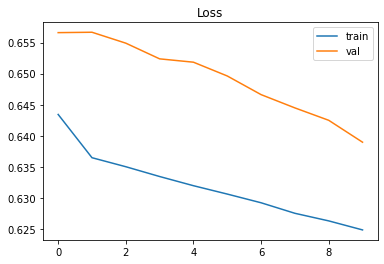

In [19]:
plt.plot(losses, label='train')
plt.plot(val_losses, label='val')
plt.title('Loss')
plt.legend()

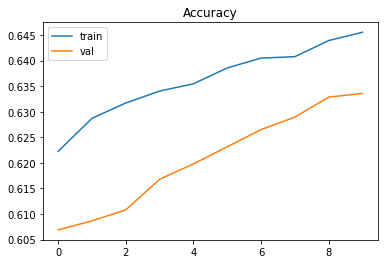

In [21]:
plt.plot(accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.title('Accuracy')
plt.legend()

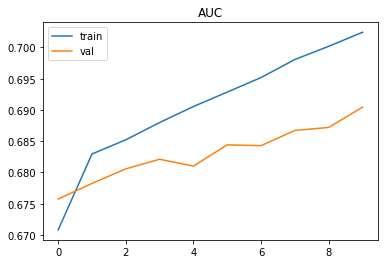

In [20]:
plt.plot(auc, label='train')
plt.plot(val_auc, label='val')
plt.title('AUC')
plt.legend()